In [1]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

### Current decay function

In [2]:
MAX_DAYS = 9999
MIN_DAYS = 0

class Anchor:
    def __init__(self, days, decayFactor, decayValue):
        self.days = days
        self.decayFactor = decayFactor
        self.decayValue = decayValue

anchors = [Anchor(MIN_DAYS, 1.0, -11.5), 
           Anchor(365, 0.90, math.log((1 /0.90) - 1)), 
           Anchor(730, 0.70, math.log((1 /0.70) - 1)), 
           Anchor(1825, 0.25, math.log((1 /0.25) - 1)), 
           Anchor(MAX_DAYS, 0.0, 11.5)]

def currentDecay(days):
    t = min(days, 9999)
    i = 0
    for elem in anchors:
        if t <= elem.days:
            break
        i = i + 1
    if i == 0:
        i = 1
    # calculating decay value for given input number of days
    tl = anchors[i - 1].days
    xl = anchors[i - 1].decayValue
    th = anchors[i].days
    xh = anchors[i].decayValue
    x = xl + (t - tl) / (th - tl) * (xh - xl)
    return 1 / (1 + math.exp(x))

### Proposed decay function

Borrowed from [stackexchange answer](https://math.stackexchange.com/questions/2390203/logarithmic-decay-weighting-factor)

In [3]:
class CubicPolunomialDecay:

    '''
    decay of general form ax^3 + bx^2 + d
    where a = (2d - kt)/t^3,
          b = (kt - 3d)/t^2,
          d is the value at x=0 (i.e. without decay),
          t is the maximum value x can take, and
          k is the slope at x=t
    d,t,k are provided as constructor parameter valueWithoutDecay, maxDuration and slopeAtMax respectively 
    values of k > 3d/t are not allowed since they would give decayed value greater than d (initial value)
    
    when k is not provided, the equation is reduced to the form ax^3 + d
    where a = -d/t^3
    this case ensures that the decayed value is never greater then d (initial value)

    '''

    def __init__(self, maxDuration, valueWithoutDecay, slopeAtMax='log'):
        '''
        maxDuration: maximum duration until which decay is to be done. at this point the value decays to 0
        valueWithoutDecay: the value without decay at duration 0
        slopeAtMax: rate of decay at the start (duration=0); possible values can be 'log','optimum' or a float value specifying the initial decay
        the inputs should satisfy the inequality slopeAtMax <= (3*valueWithoutDecay)/maxDuration
        '''
        if slopeAtMax is None or maxDuration is None or valueWithoutDecay is None:
            raise Exception('all values (maxDuration, valueWithoutDecay, slopeAtMax) are required')
        
        if slopeAtMax == 'log':
            k = (3 * valueWithoutDecay) / maxDuration
        elif slopeAtMax == 'optimum':
            k = (3 * valueWithoutDecay) / (maxDuration * math.exp(5))
        elif type(slopeAtMax) in (int, float):
            if slopeAtMax > 3*valueWithoutDecay/maxDuration:
                errorMessage = "inequality not satisfied: [slopeAtMax:{2}] <= 3*[valueWithoutDecay:{1}]/[maxDuration:{0}]".format(maxDuration,valueWithoutDecay,slopeAtMax)
                raise Exception(errorMessage)
            k = slopeAtMax
        else:
            raise Exception("possible values of slopeAtMax can be 'log','optimum' or a float value")

        self.maxDuration = maxDuration
        self.a = (2*valueWithoutDecay - k*maxDuration)/math.pow(maxDuration,3)
        self.b = (k*maxDuration - 3*valueWithoutDecay)/math.pow(maxDuration,2)
        self.d = valueWithoutDecay

    def get_decay(self, duration):
        if duration < 0 or duration > self.maxDuration:
            return 0.
        return self.a*math.pow(duration,3) + self.b*math.pow(duration,2) + self.d

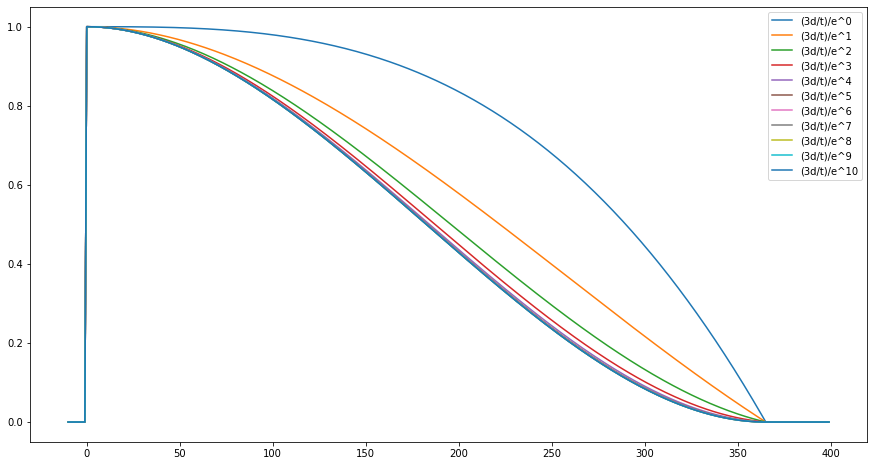

In [4]:
plt.figure(figsize=(15,8))
for y in range(0,11):
    d = 1
    t = 365
    s = (3*d)/(t*math.exp(y))
    proposedDecay1 = CubicPolunomialDecay(maxDuration=t,valueWithoutDecay=d, slopeAtMax=s)
    _range = range(-10,400,1)
    l = [proposedDecay1.get_decay(i) for i in _range]
    sns.lineplot(_range, l, label='(3d/t)/e^{}'.format(y))

### Exponential decay


more details [here](https://mathworld.wolfram.com/ExponentialDecay.html)

In [5]:
class ExponentialDecay:

    '''
    decay of general form ne^(-k)t
    where n = valueWithoutDecay
          k = decayConstant
    '''

    def __init__(self, valueWithoutDecay, decayConstant):
        if decayConstant is None or valueWithoutDecay is None:
            raise Exception('all values (valueWithoutDecay, decayConstant) are required')
        self.n = valueWithoutDecay
        self.k = decayConstant

    def get_decay(self, duration):
        if duration < 0:
            return 0.
        return self.n *math.exp(-1 * self.k * duration)

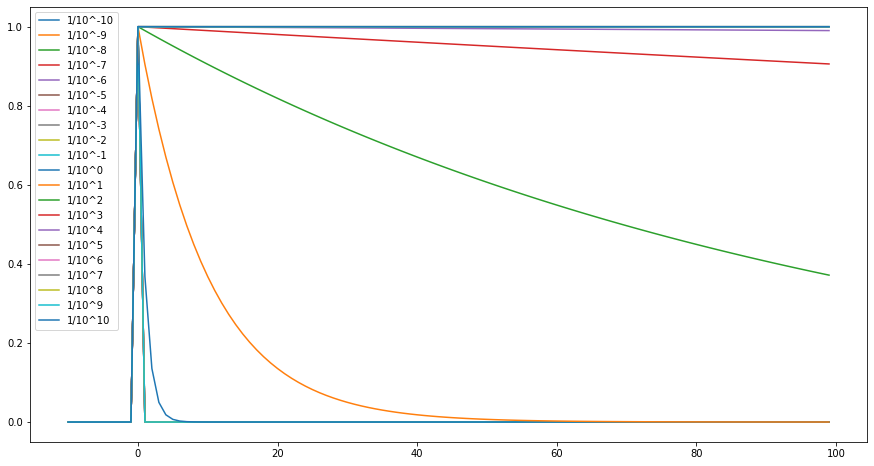

In [6]:
plt.figure(figsize=(15,8))
for y in range(-10,11):
    d = 1
    k = 1/math.pow(10,y)
    proposedDecayExp = ExponentialDecay(valueWithoutDecay=d, decayConstant=k)
    _range = range(-10,100,1)
    l = [proposedDecayExp.get_decay(i) for i in _range]
    sns.lineplot(_range, l, label='1/10^{}'.format(y))

### Comparision

In [7]:
d = 1
t = 365*5
cubicPolunomialDecayLog = CubicPolunomialDecay(maxDuration=t,valueWithoutDecay=d, slopeAtMax='log')
cubicPolunomialDecayOptimum = CubicPolunomialDecay(maxDuration=t,valueWithoutDecay=d, slopeAtMax='optimum')
cubicPolunomialDecay = CubicPolunomialDecay(maxDuration=t,valueWithoutDecay=d, slopeAtMax=(3*d)/(10*t))
exponentialDecay = ExponentialDecay(valueWithoutDecay=d, decayConstant=0.001)

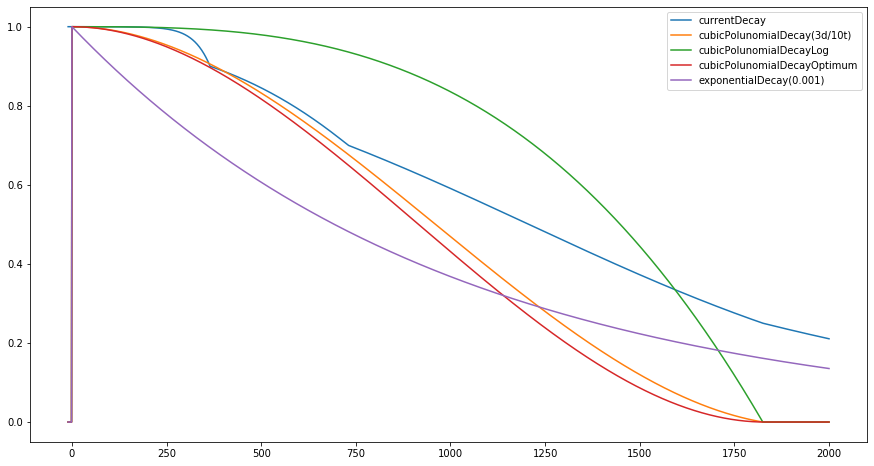

In [8]:
plt.figure(figsize=(15,8))
sns.lineplot(range(-10,2001,1), [currentDecay(i) for i in range(-10,2001,1)],label='currentDecay')
sns.lineplot(range(-10,2001,1), [cubicPolunomialDecay.get_decay(i) for i in range(-10,2001,1)],label='cubicPolunomialDecay(3d/10t)')
sns.lineplot(range(-10,2001,1), [cubicPolunomialDecayLog.get_decay(i) for i in range(-10,2001,1)],label='cubicPolunomialDecayLog')
sns.lineplot(range(-10,2001,1), [cubicPolunomialDecayOptimum.get_decay(i) for i in range(-10,2001,1)],label='cubicPolunomialDecayOptimum')
sns.lineplot(range(-10,2001,1), [exponentialDecay.get_decay(i) for i in range(-10,2001,1)],label='exponentialDecay(0.001)')